# Multi-Target Prediction

We will use the [KIBA benchmark dataset](https://researchportal.helsinki.fi/en/datasets/kiba-a-benchmark-dataset-for-drug-target-prediction) of kinase inhibitor bioactivities as our example. KIBA is a large-scale drug-target binding affinity dataset originally containing 52,498 compounds and 467 kinase targets (246,088 affinity values). Each record is a drug-protein pair labeled with a continuous affinity score. We will load the dataset in PyTorch, explore its structure, and then implement three modeling approaches:


1. a basic matrix factorization via SVD
2. a two-branch neural network using learned embeddings
3. an extended two-branch network that also uses explicit drug/protein features to allow zero-shot prediction on new drugs or targets.

In [1]:
!pip install rdkit
!pip install pyTDC

In [2]:
from tdc.multi_pred import DTI
data = DTI(name = 'KIBA')
df = data.get_data() # contains columns: Drug, Target, Y, SMILES, Sequence

Downloading...
100%|██████████| 96.6M/96.6M [00:02<00:00, 34.5MiB/s]
Loading...
Done!


In [3]:
df

,Drug_ID,Drug,Target_ID,Target,Y
0,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O00141,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.10000
1,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O14920,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.10000
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O15111,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.10000
3,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,11.10000
4,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P04626,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.10000
...,...,...,...,...,...
117652,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13554,MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...,10.49794
117653,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13555,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,10.49794
117654,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13557,MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...,10.49794
117655,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q16539,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,10.49794


Our task is regression: given a drug-protein pair, predict the binding affinity score. As we can see right now the data is represented with every interaction as a row. We can also represent it as a matrix with missing values.

The following figure shows the different multi-target prediction settings, depending on the goal of the project.

In the first two sections we will look at Setting A, which is a a matrix-completion problem. Afterwards, we will look at settings where we want to predict the affinity for unseen drugs or proteins.

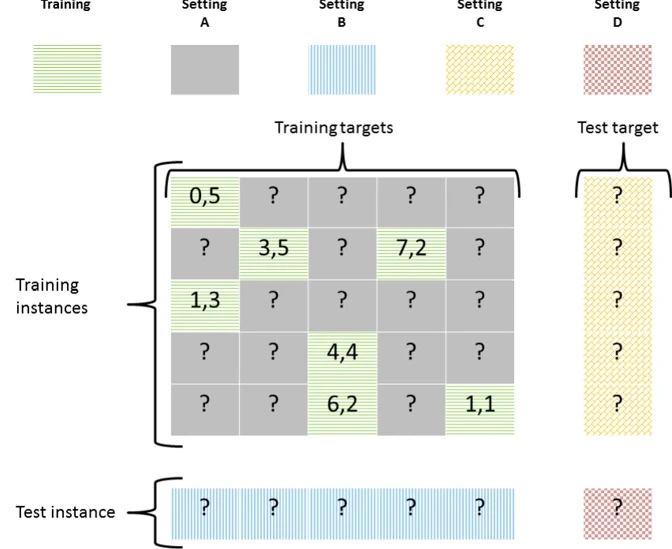

# 1. Matrix Factorization (Singular Value Decomposition)
A simple first approach is matrix factorization via SVD, which decomposes the interaction matrix into latent factors.

In [ ]:
import pandas as pd
import numpy as np
from tdc.multi_pred import DTI

# Load data and get split from TDC
data = DTI(name = 'KIBA')
split = data.get_split()

train_df = split['train']
val_df = split['valid']
test_df = split['test']

Found local copy...
Loading...
Done!


Now we will build the matrix (only with the training data), missing values are filled with zeros.

In [ ]:
# Build index mapping and interaction matrix using training data only
drugs = sorted(pd.concat([train_df['Drug_ID'], val_df["Drug_ID"], test_df['Drug_ID']]).unique())
prots = sorted(pd.concat([train_df['Target_ID'], val_df["Target_ID"], test_df['Target_ID']]).unique())
drug_to_idx = {d:i for i,d in enumerate(drugs)}
prot_to_idx = {p:i for i,p in enumerate(prots)}

M_train = np.zeros((len(drugs), len(prots)))
for _, row in train_df.iterrows():
    i = drug_to_idx[row['Drug_ID']]
    j = prot_to_idx[row['Target_ID']]
    M_train[i, j] = row['Y']  # affinity score

print("Training interaction matrix shape:", M_train.shape)

Training interaction matrix shape: (2068, 229)


And perform the SVD.

In [ ]:
# Perform truncated SVD on the training matrix
from sklearn.utils.extmath import randomized_svd
k = 64  # latent dimension (chosen hyperparameter)
U, S, VT = randomized_svd(M_train, n_components=k, random_state=42)

print(f"SVD performed with k={k}")
print("Original matrix shape: ", M_train.shape)
print("U shape:", U.shape)
print("S shape:", S.shape)
print("VT shape:", VT.shape)

M_recon = U.dot(np.diag(S)).dot(VT)
print("Reconstructed matrix shape: ", M_recon.shape)


SVD performed with k=64
Original matrix shape:  (2068, 229)
U shape: (2068, 64)
S shape: (64,)
VT shape: (64, 229)
Reconstructed matrix shape:  (2068, 229)


In [ ]:
# Evaluate on training set
mask = (M_train != 0)
mse = np.mean((M_recon[mask] - M_train[mask])**2)
print("train MSE: ", mse)

train MSE:  11.043778255971814


In [ ]:
# Evaluate on test set

test_pred = []
test_true = []
for _, row in test_df.iterrows():
    i = drug_to_idx[row['Drug_ID']]
    j = prot_to_idx[row['Target_ID']]
    test_pred.append(M_recon[i, j])
    test_true.append(row['Y'])

test_pred = np.array(test_pred)
test_true = np.array(test_true)

mse = np.mean((test_pred - test_true)**2)

print(f"Test MSE (k={k}):", mse)

Test MSE (k=64): 77.64945781454135


# 2. Two-Branch Neural Network
A more flexible method is a two-branch neural network that embeds each drug and protein via learnable layers, then combines them to predict affinity.
Here we use simple embedding layers + MLP. Concretely, each drug index and protein index is mapped to a trainable embedding vector (size emb_dim), then concatenated and passed through an MLP to output one affinity score. The model is:

$$\hat{y}_{dp}=f(e_d,e_p),$$

where $\mathbf{e}_d$ and $\mathbf{e}_p$ are embedding vectors for drug $d$ and protein $p$. We then minimize MSE loss on known interactions.

**Exercise:** Implement the two-branch neural network model and train it on the training data. Evaluate its performance on the test set using MSE. Use embedding layers for the input of the different branches, and a simple MLP to merge the branches and to make the final prediction.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tdc.multi_pred import DTI
import numpy as np

# Implement Two branch NN
class TwoBranchNN(nn.Module):
    def __init__(self, num_drugs, num_prots, emb_dim=64, hidden_dim=32):
        super().__init__()
        self.drug_emb = nn.Embedding(num_drugs, emb_dim)
        self.prot_emb = nn.Embedding(num_prots, emb_dim)
        self.fc1 = nn.Linear(emb_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, d_idx, p_idx):
        d = self.drug_emb(d_idx)
        p = self.prot_emb(p_idx)
        x = torch.cat([d, p], dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

In [10]:
# Prepare data tensors
train_d_idx = torch.LongTensor([drug_to_idx[d] for d in train_df['Drug_ID']])
train_p_idx = torch.LongTensor([prot_to_idx[p] for p in train_df['Target_ID']])
train_y = torch.FloatTensor(train_df['Y'].values)

val_d_idx = torch.LongTensor([drug_to_idx[d] for d in val_df['Drug_ID']])
val_p_idx = torch.LongTensor([prot_to_idx[p] for p in val_df['Target_ID']])
val_y = torch.FloatTensor(val_df['Y'].values)

test_d_idx = torch.LongTensor([drug_to_idx[d] for d in test_df['Drug_ID']])
test_p_idx = torch.LongTensor([prot_to_idx[p] for p in test_df['Target_ID']])
test_y = torch.FloatTensor(test_df['Y'].values)


train_ds = TensorDataset(train_d_idx, train_p_idx, train_y)
val_ds  = TensorDataset(val_d_idx,  val_p_idx,  val_y)
test_ds  = TensorDataset(test_d_idx,  test_p_idx,  test_y)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_loader  = DataLoader(val_ds,  batch_size=1024)
test_loader  = DataLoader(test_ds,  batch_size=1024)

# Instantiate model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchNN(len(drugs), len(prots), emb_dim=64, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(50):
    model.train()
    for d_batch, p_batch, y_batch in train_loader:
        d_batch, p_batch, y_batch = d_batch.to(device), p_batch.to(device), y_batch.to(device)
        pred = model(d_batch, p_batch)
        loss = loss_fn(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_pred = []
        val_true = []
        for d_batch, p_batch, y_batch in val_loader:
            d_batch, p_batch = d_batch.to(device), p_batch.to(device)
            out = model(d_batch, p_batch)
            val_pred.append(out.cpu())
            val_true.append(y_batch)
        val_pred = torch.cat(val_pred).numpy()
        val_true = torch.cat(val_true).numpy()
        mse = ((val_pred - val_true)**2).mean()
        print(f"Epoch {epoch+1}: validation MSE = {mse:.3f}")

# Final evaluation on test set
model.eval()
with torch.no_grad():
    test_pred = []
    test_true = []
    for d_batch, p_batch, y_batch in test_loader:
        d_batch, p_batch = d_batch.to(device), p_batch.to(device)
        out = model(d_batch, p_batch)
        test_pred.append(out.cpu())
        test_true.append(y_batch)
    test_pred = torch.cat(test_pred).numpy()
    test_true = torch.cat(test_true).numpy()
    test_mse = ((test_pred - test_true)**2).mean()
    print(f"\nFinal test MSE = {test_mse:.3f}")

Epoch 1: validation MSE = 49.714
Epoch 2: validation MSE = 6.154
Epoch 3: validation MSE = 1.724
Epoch 4: validation MSE = 1.039
Epoch 5: validation MSE = 0.869
Epoch 6: validation MSE = 0.776
Epoch 7: validation MSE = 0.711
Epoch 8: validation MSE = 0.663
Epoch 9: validation MSE = 0.629
Epoch 10: validation MSE = 0.602
Epoch 11: validation MSE = 0.584
Epoch 12: validation MSE = 0.566
Epoch 13: validation MSE = 0.550
Epoch 14: validation MSE = 0.538
Epoch 15: validation MSE = 0.524
Epoch 16: validation MSE = 0.514
Epoch 17: validation MSE = 0.500
Epoch 18: validation MSE = 0.490
Epoch 19: validation MSE = 0.478
Epoch 20: validation MSE = 0.472
Epoch 21: validation MSE = 0.462
Epoch 22: validation MSE = 0.451
Epoch 23: validation MSE = 0.445
Epoch 24: validation MSE = 0.439
Epoch 25: validation MSE = 0.433
Epoch 26: validation MSE = 0.426
Epoch 27: validation MSE = 0.420
Epoch 28: validation MSE = 0.414
Epoch 29: validation MSE = 0.415
Epoch 30: validation MSE = 0.409
Epoch 31: validati

# 3. Extended Two-Branch Model with Features (Zero-Shot Prediction)

To generalize to new drugs or proteins (zero-shot prediction), we incorporate explicit features of compounds and proteins alongside embeddings. For example, we can compute a molecular fingerprint for each SMILES string, and a simple composition-based vector for each protein sequence.

These features can replace our ID embeddings or be used in addition to them, we will do the latter. The model now has two inputs per branch: (i) the ID embedding and (ii) the explicit feature vector. These are concatenated to produce the branch representation.

Explicitly, each drug’s SMILES is converted to a fixed-length fingerprint (e.g. 1024-bit Morgan fingerprint), and each protein sequence to a numeric feature (e.g. counts of amino acids). These allow the model to form a prediction even if the drug or protein was not seen during training (it still has features). Formally, incorporating features enables prediction on new drug/target combinations.

**Exercise:** Implement this extended two-branch model that uses both ID embeddings and explicit features for drugs and proteins. Train it on the training data and evaluate its performance on the test set using MSE. Test its ability to predict interactions involving new drugs not seen during training. 

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from tdc.multi_pred import DTI
import pandas as pd
from tqdm import tqdm
import random


data = DTI(name='KIBA')
split = data.get_split(method='cold_drug')  # drug-holdout split

train_df, val_df, test_df = split['train'], split['valid'], split['test']

drug_ids = sorted(pd.concat([train_df['Drug_ID'], val_df['Drug_ID'], test_df['Drug_ID']]).unique())
prot_ids = sorted(pd.concat([train_df['Target_ID'], val_df['Target_ID'], test_df['Target_ID']]).unique())

drug_to_idx = {d: i for i, d in enumerate(drug_ids)}
prot_to_idx = {p: i for i, p in enumerate(prot_ids)}

full_df = data.get_data()
drug_smiles_map = full_df.set_index('Drug_ID')['Drug'].to_dict()
prot_seq_map = full_df.set_index('Target_ID')['Target'].to_dict()

num_bits = 512
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

def morgan_fp(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return np.zeros(num_bits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=num_bits)
    arr = np.zeros((num_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def aa_counts(seq):
    return np.array([seq.count(aa) for aa in amino_acids])

# Compute and cache features
drug_feat_map = {d: morgan_fp(drug_smiles_map[d]) for d in drug_ids}
prot_feat_map = {p: aa_counts(prot_seq_map[p]) for p in prot_ids}

# Convert to tensors
drug_feat_tensor = torch.FloatTensor([drug_feat_map[d] for d in drug_ids])
prot_feat_tensor = torch.FloatTensor([prot_feat_map[p] for p in prot_ids])


# Dataset construction

def make_tensor_dataset(df):
    d_idx = torch.LongTensor([drug_to_idx[d] for d in df['Drug_ID']])
    p_idx = torch.LongTensor([prot_to_idx[p] for p in df['Target_ID']])
    y = torch.FloatTensor(df['Y'].values)
    d_feat = drug_feat_tensor[d_idx]
    p_feat = prot_feat_tensor[p_idx]
    return TensorDataset(d_idx, p_idx, y, d_feat, p_feat)

train_ds = make_tensor_dataset(train_df)
val_ds   = make_tensor_dataset(val_df)
test_ds  = make_tensor_dataset(test_df)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256)
test_loader  = DataLoader(test_ds, batch_size=256)


# Model definition

class TwoBranchWithFeatures(nn.Module):
    def __init__(self, num_drugs, num_prots, emb_dim=64, feat_drug_dim=512, feat_prot_dim=20, hidden_dim=128):
        super().__init__()
        # ID embeddings
        self.drug_emb = nn.Embedding(num_drugs, emb_dim)
        self.prot_emb = nn.Embedding(num_prots, emb_dim)

        # Two-layer MLP per branch on concatenated [ID embedding | features]
        self.drug_mlp1 = nn.Linear(emb_dim + feat_drug_dim, hidden_dim)
        self.drug_mlp2 = nn.Linear(hidden_dim, hidden_dim)

        self.prot_mlp1 = nn.Linear(emb_dim + feat_prot_dim, hidden_dim)
        self.prot_mlp2 = nn.Linear(hidden_dim, hidden_dim)

        # Two-layer head after concatenating both branches
        self.post1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.post2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, d_idx, p_idx, d_feat, p_feat):
        # Concatenate ID embeddings with raw features
        d = torch.cat([self.drug_emb(d_idx), d_feat], dim=-1)
        p = torch.cat([self.prot_emb(p_idx), p_feat], dim=-1)

        # Two linear layers per branch
        d = F.relu(self.drug_mlp1(d))
        d = F.relu(self.drug_mlp2(d))
        
        p = F.relu(self.prot_mlp1(p))
        p = F.relu(self.prot_mlp2(p))

        # Concatenate branches and pass through two more layers
        x = torch.cat([d, p], dim=-1)
        x = F.relu(self.post1(x))
        x = F.relu(self.post2(x))

        # Output
        x = self.out(x)
        return x.squeeze(-1)

# Training loop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchWithFeatures(len(drug_ids), len(prot_ids)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1, 51):
    model.train()
    train_loss = 0
    for d_idx, p_idx, y, d_feat, p_feat in tqdm(train_loader, desc=f"Epoch {epoch}"):
        d_idx, p_idx, y, d_feat, p_feat = d_idx.to(device), p_idx.to(device), y.to(device), d_feat.to(device), p_feat.to(device)
        pred = model(d_idx, p_idx, d_feat, p_feat)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(y)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    with torch.no_grad():
        preds, targets = [], []
        for d_idx, p_idx, y, d_feat, p_feat in val_loader:
            d_idx, p_idx, d_feat, p_feat = d_idx.to(device), p_idx.to(device), d_feat.to(device), p_feat.to(device)
            out = model(d_idx, p_idx, d_feat, p_feat)
            preds.append(out.cpu())
            targets.append(y)
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        val_mse = ((preds - targets) ** 2).mean().item()
    print(f"Epoch {epoch}: train MSE={train_loss:.4f}, val MSE={val_mse:.4f}")


# Final test evaluation

model.eval()
with torch.no_grad():
    preds, targets = [], []
    for d_idx, p_idx, y, d_feat, p_feat in test_loader:
        d_idx, p_idx, d_feat, p_feat = d_idx.to(device), p_idx.to(device), d_feat.to(device), p_feat.to(device)
        out = model(d_idx, p_idx, d_feat, p_feat)
        preds.append(out.cpu())
        targets.append(y)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    test_mse = ((preds - targets) ** 2).mean().item()
print(f"\nFinal test MSE (drug-holdout) = {test_mse:.3f}")


Found local copy...
Loading...
Done!
Epoch 1: 100%|██████████| 323/323 [00:03<00:00, 84.10it/s]


Epoch 1: train MSE=4.2855, val MSE=2.5237


Epoch 2: 100%|██████████| 323/323 [00:05<00:00, 60.96it/s]


Epoch 2: train MSE=0.5999, val MSE=2.5641


Epoch 3: 100%|██████████| 323/323 [00:03<00:00, 82.05it/s]


Epoch 3: train MSE=0.4292, val MSE=2.6961


Epoch 4: 100%|██████████| 323/323 [00:03<00:00, 86.86it/s]


Epoch 4: train MSE=0.3823, val MSE=2.6888


Epoch 5: 100%|██████████| 323/323 [00:04<00:00, 64.85it/s]


Epoch 5: train MSE=0.3670, val MSE=2.8319


Epoch 6: 100%|██████████| 323/323 [00:03<00:00, 89.31it/s]


Epoch 6: train MSE=0.3538, val MSE=2.8648


Epoch 7: 100%|██████████| 323/323 [00:03<00:00, 83.15it/s]


Epoch 7: train MSE=0.3424, val MSE=2.8388


Epoch 8: 100%|██████████| 323/323 [00:04<00:00, 68.59it/s]


Epoch 8: train MSE=0.3382, val MSE=2.7361


Epoch 9: 100%|██████████| 323/323 [00:03<00:00, 86.03it/s]


Epoch 9: train MSE=0.3262, val MSE=2.8917


Epoch 10: 100%|██████████| 323/323 [00:03<00:00, 91.70it/s]


Epoch 10: train MSE=0.3254, val MSE=2.6089


Epoch 11: 100%|██████████| 323/323 [00:04<00:00, 70.16it/s]


Epoch 11: train MSE=0.3114, val MSE=2.5976


Epoch 12: 100%|██████████| 323/323 [00:03<00:00, 81.67it/s]


Epoch 12: train MSE=0.3007, val MSE=2.5298


Epoch 13: 100%|██████████| 323/323 [00:03<00:00, 93.44it/s]


Epoch 13: train MSE=0.2984, val MSE=2.4404


Epoch 14: 100%|██████████| 323/323 [00:04<00:00, 69.42it/s]


Epoch 14: train MSE=0.2937, val MSE=2.4566


Epoch 15: 100%|██████████| 323/323 [00:03<00:00, 92.08it/s]


Epoch 15: train MSE=0.2806, val MSE=2.3657


Epoch 16: 100%|██████████| 323/323 [00:03<00:00, 85.43it/s]


Epoch 16: train MSE=0.2781, val MSE=2.3663


Epoch 17: 100%|██████████| 323/323 [00:04<00:00, 72.70it/s]


Epoch 17: train MSE=0.2723, val MSE=2.3558


Epoch 18: 100%|██████████| 323/323 [00:03<00:00, 85.72it/s]


Epoch 18: train MSE=0.2686, val MSE=2.3298


Epoch 19: 100%|██████████| 323/323 [00:03<00:00, 91.02it/s]


Epoch 19: train MSE=0.2626, val MSE=2.3386


Epoch 20: 100%|██████████| 323/323 [00:04<00:00, 68.70it/s]


Epoch 20: train MSE=0.2624, val MSE=2.3348


Epoch 21: 100%|██████████| 323/323 [00:03<00:00, 91.78it/s]


Epoch 21: train MSE=0.2527, val MSE=2.2611


Epoch 22: 100%|██████████| 323/323 [00:03<00:00, 84.58it/s]


Epoch 22: train MSE=0.2520, val MSE=2.3417


Epoch 23: 100%|██████████| 323/323 [00:04<00:00, 74.64it/s]


Epoch 23: train MSE=0.2437, val MSE=2.2590


Epoch 24: 100%|██████████| 323/323 [00:03<00:00, 86.06it/s]


Epoch 24: train MSE=0.2407, val MSE=2.2130


Epoch 25: 100%|██████████| 323/323 [00:03<00:00, 93.03it/s]


Epoch 25: train MSE=0.2371, val MSE=2.2169


Epoch 26: 100%|██████████| 323/323 [00:04<00:00, 69.67it/s]


Epoch 26: train MSE=0.2351, val MSE=2.1964


Epoch 27: 100%|██████████| 323/323 [00:03<00:00, 93.19it/s]


Epoch 27: train MSE=0.2298, val MSE=2.3116


Epoch 28: 100%|██████████| 323/323 [00:03<00:00, 85.28it/s]


Epoch 28: train MSE=0.2271, val MSE=2.2999


Epoch 29: 100%|██████████| 323/323 [00:07<00:00, 43.96it/s]


Epoch 29: train MSE=0.2238, val MSE=2.2084


Epoch 30: 100%|██████████| 323/323 [00:10<00:00, 32.09it/s]


Epoch 30: train MSE=0.2169, val MSE=2.2111


Epoch 31: 100%|██████████| 323/323 [00:03<00:00, 90.21it/s]


Epoch 31: train MSE=0.2176, val MSE=2.1946


Epoch 32: 100%|██████████| 323/323 [00:03<00:00, 85.24it/s]


Epoch 32: train MSE=0.2078, val MSE=2.2696


Epoch 33: 100%|██████████| 323/323 [00:04<00:00, 70.98it/s]


Epoch 33: train MSE=0.2081, val MSE=2.1613


Epoch 34: 100%|██████████| 323/323 [00:03<00:00, 90.71it/s]


Epoch 34: train MSE=0.2045, val MSE=2.1586


Epoch 35: 100%|██████████| 323/323 [00:03<00:00, 92.47it/s]


Epoch 35: train MSE=0.1996, val MSE=2.1889


Epoch 36: 100%|██████████| 323/323 [00:04<00:00, 72.36it/s]


Epoch 36: train MSE=0.1974, val MSE=2.1980


Epoch 37: 100%|██████████| 323/323 [00:03<00:00, 85.82it/s]


Epoch 37: train MSE=0.1961, val MSE=2.1409


Epoch 38: 100%|██████████| 323/323 [00:03<00:00, 92.44it/s]


Epoch 38: train MSE=0.1920, val MSE=2.1365


Epoch 39: 100%|██████████| 323/323 [00:04<00:00, 68.06it/s]


Epoch 39: train MSE=0.1889, val MSE=2.0917


Epoch 40: 100%|██████████| 323/323 [00:03<00:00, 91.06it/s]


Epoch 40: train MSE=0.1844, val MSE=2.1786


Epoch 41: 100%|██████████| 323/323 [00:03<00:00, 83.39it/s]


Epoch 41: train MSE=0.1811, val MSE=2.1551


Epoch 42: 100%|██████████| 323/323 [00:04<00:00, 71.50it/s]


Epoch 42: train MSE=0.1779, val MSE=2.1719


Epoch 43: 100%|██████████| 323/323 [00:03<00:00, 84.25it/s]


Epoch 43: train MSE=0.1784, val MSE=2.0845


Epoch 44: 100%|██████████| 323/323 [00:03<00:00, 91.46it/s]


Epoch 44: train MSE=0.1756, val MSE=2.1220


Epoch 45: 100%|██████████| 323/323 [00:04<00:00, 69.38it/s]


Epoch 45: train MSE=0.1713, val MSE=2.0954


Epoch 46: 100%|██████████| 323/323 [00:03<00:00, 89.62it/s]


Epoch 46: train MSE=0.1709, val MSE=2.0380


Epoch 47: 100%|██████████| 323/323 [00:04<00:00, 76.14it/s]


Epoch 47: train MSE=0.1671, val MSE=2.0455


Epoch 48: 100%|██████████| 323/323 [00:04<00:00, 73.85it/s]


Epoch 48: train MSE=0.1631, val MSE=2.0471


Epoch 49: 100%|██████████| 323/323 [00:03<00:00, 82.55it/s]


Epoch 49: train MSE=0.1607, val MSE=2.0677


Epoch 50: 100%|██████████| 323/323 [00:04<00:00, 80.34it/s]


Epoch 50: train MSE=0.1589, val MSE=1.9977

Final test MSE (drug-holdout) = 1.961


In [ ]:
# Final test evaluation

model.eval()
with torch.no_grad():
    preds, targets = [], []
    for d_idx, p_idx, y, d_feat, p_feat in test_loader:
        d_idx, p_idx, d_feat, p_feat = d_idx.to(device), p_idx.to(device), d_feat.to(device), p_feat.to(device)
        out = model(d_idx, p_idx, d_feat, p_feat)
        preds.append(out.cpu())
        targets.append(y)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    test_mse = ((preds - targets) ** 2).mean().item()
print(f"\nFinal test MSE (drug-holdout) = {test_mse:.3f}")